In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import itertools

from sklearn.metrics import roc_auc_score, r2_score, accuracy_score

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [3]:
data=pd.read_csv("../data/raw/databinarystudents.csv")

## Selección de características

In [4]:
sel_fea = []
coefi = []

for j in range(1,101):
    
    train, test = train_test_split(data, test_size = 0.2, random_state=j)
    train=train.drop(['id'], axis=1)
    X_train=train.drop(['yL'], axis=1)
    Y_train=train['yL']
    test=test.drop(['id'], axis=1)
    X_test=test.drop(['yL'], axis=1)
    Y_test=test['yL']
    
    num_features = ['x1','x2','x8','x9','x10','x11','x12','x21','x22','x23','x24','x25','x26','x27','x30','x31','x32']
    
    num_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('imputer',SimpleImputer(strategy='median'))
        ])
    col_transformer = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_features)
        ])
    
    columns=X_train.columns.values.tolist()
    col_transformer.fit(X_train.fillna(0))
    X_train[num_features]=col_transformer.transform(X_train.fillna(0))
    X_test[num_features]=col_transformer.transform(X_test.fillna(0))
    
    model_all_features = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                        l1_ratio=0.5, max_iter=10000, random_state=0)
    model_all_features.fit(X_train, Y_train)
    y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
    auc_score_all = roc_auc_score(Y_test, y_pred_test)
    
    features = pd.Series(abs(model_all_features.coef_[0,:])) # esto con valor absoluto?
    features.index = X_train.columns
    features.sort_values(ascending=False, inplace=True)
    
    features = list(features.index)
    
    # Modelo con la característca más importante (desde la que se inicia la adición)
    model_one_feature = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                        l1_ratio=0.5, max_iter=10000, random_state=0)
    model_one_feature.fit(X_train[features[0]].to_frame(), Y_train)
    
    y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
    auc_score_first = roc_auc_score(Y_test, y_pred_test)
    
    # Adición de características y evaluación de modelos, una a la vez (en orden de importancia)
    
    tol = 0.001
    features_to_keep = [features[0]]
    count = 1
    for feature in features[1:]:
        count = count + 1
        model_int = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                        l1_ratio=0.5, max_iter=10000, random_state=0)
        model_int.fit(X_train[features_to_keep + [feature] ], Y_train)
        
        y_pred_test = model_int.predict_proba(X_test[features_to_keep + [feature] ])[:, 1]
        auc_score_int = roc_auc_score(Y_test, y_pred_test)
        diff_auc = auc_score_int - auc_score_first
        
        if diff_auc >= tol:
            auc_score_first = auc_score_int
            features_to_keep.append(feature)
        #else:
            #print()
     
    # Modelo con características seleccionadas
    final_m = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                   l1_ratio=0.5, max_iter=10000, random_state=0)
    final_m.fit(X_train[features_to_keep], Y_train)
    
    y_pred_test = final_m.predict_proba(X_test[features_to_keep])[:,1]
    
    ROC_AUC_final = roc_auc_score(Y_test, y_pred_test)
    y_pred_test1 = final_m.predict(X_test[features_to_keep])
    acc = accuracy_score(Y_test, y_pred_test1)
    
    finalcoe = final_m.coef_.tolist()
    
    sel_fea.extend(features_to_keep)
    coefi.extend(finalcoe)

In [5]:
coefi = list(itertools.chain.from_iterable(coefi))

#### Coeficientes y características seleccionadas

In [6]:
summar = pd.concat([pd.DataFrame(sel_fea), pd.DataFrame(coefi)],axis=1)

In [7]:
summar.columns=['selected_feature','coefficient']

Ditribución de los coeficientes por característica

C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed i

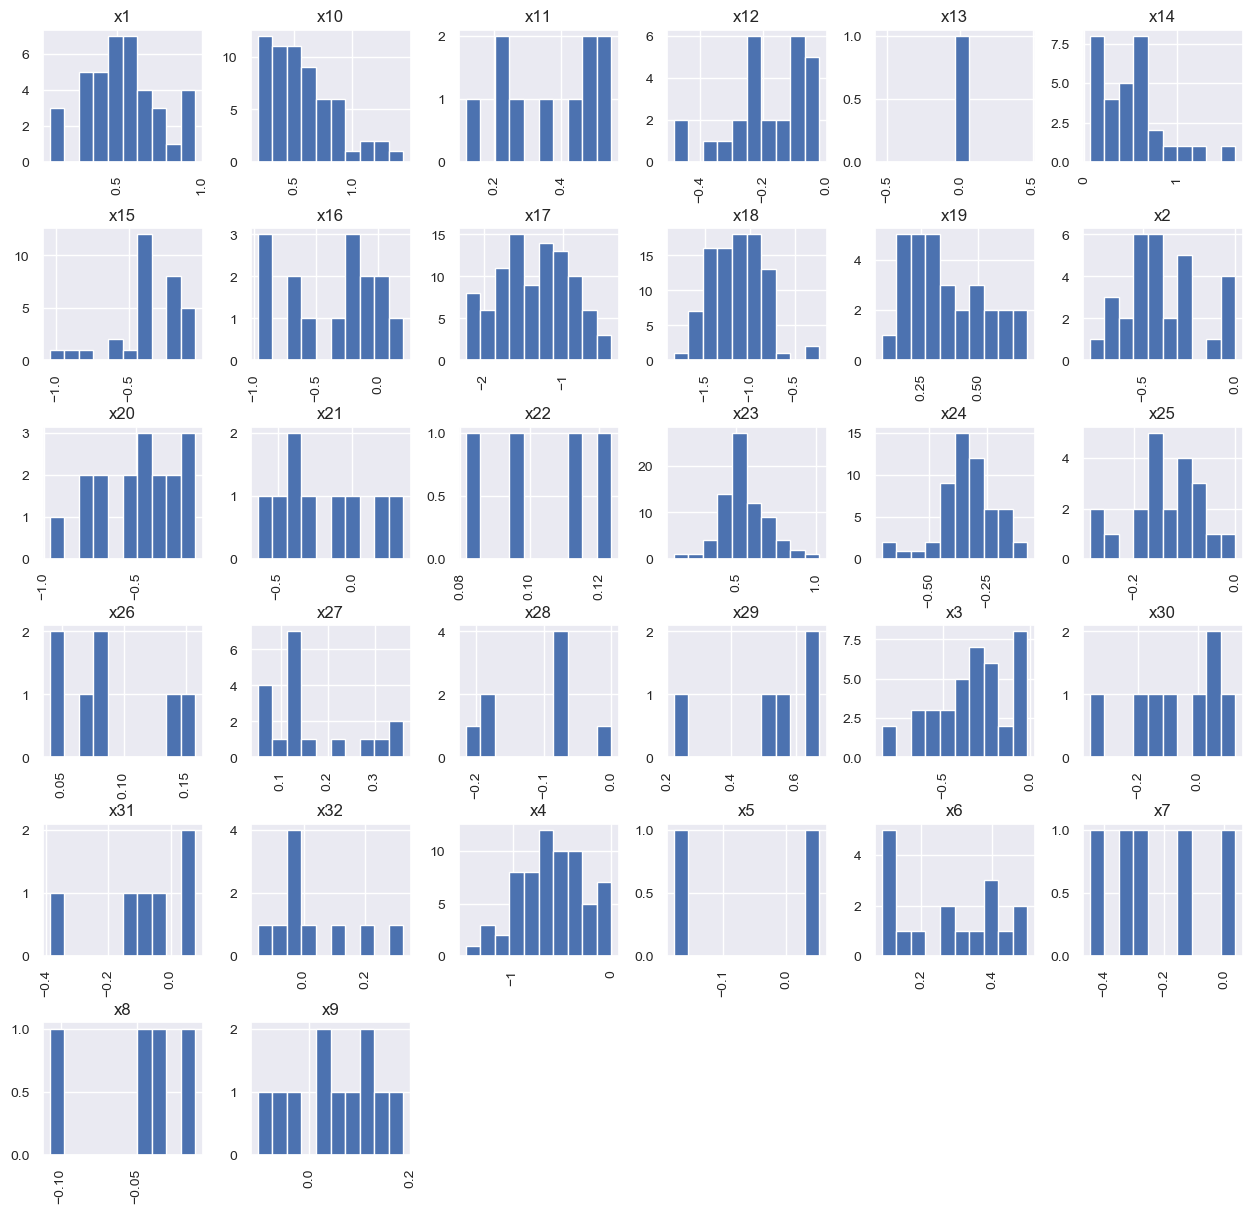

In [8]:
import seaborn.apionly as snsa
snsa.set()
summar.hist(by='selected_feature', column ='coefficient', xlabelsize=10, ylabelsize=10, figsize=(15,15))
plt.show()

Probabilidad de selección de cada variable

In [9]:
summar['selected_feature'].value_counts()

x17    95
x18    92
x23    75
x4     66
x10    61
x24    56
x3     39
x1     39
x15    31
x14    31
x2     30
x19    30
x12    27
x25    21
x27    18
x6     17
x20    17
x16    15
x9     11
x32    10
x11    10
x21     9
x30     8
x28     8
x26     7
x31     6
x7      5
x29     5
x8      4
x22     4
x5      2
x13     1
Name: selected_feature, dtype: int64

## Entrenamiento del modelo

In [10]:
roc = []
accur = []

for j in range(1+1000,101+1000):
    
    train, test = train_test_split(data, test_size = 0.2, random_state=j)
    train=train.drop(['id'], axis=1)
    X_train=train.drop(['yL'], axis=1)
    Y_train=train['yL']
    test=test.drop(['id'], axis=1)
    X_test=test.drop(['yL'], axis=1)
    Y_test=test['yL']
    
    num_features = ['x1','x2','x8','x9','x10','x11','x12','x21','x22','x23','x24','x25','x26','x27','x30','x31','x32']
    
    num_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('imputer',SimpleImputer(strategy='median'))
        ])
    col_transformer = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_features)
        ])
    
    columns=X_train.columns.values.tolist()
    col_transformer.fit(X_train.fillna(0))
    X_train[num_features]=col_transformer.transform(X_train.fillna(0))
    X_test[num_features]=col_transformer.transform(X_test.fillna(0))
    
    # Modelo con características seleccionadas
    
    final_m = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                   l1_ratio=0.5, max_iter=10000, random_state=0)
    final_m.fit(X_train.filter(['x17', 'x18', 'x23', 'x4', 'x10', 'x24'], axis=1), Y_train)
    
    y_pred_test = final_m.predict_proba(X_test.filter(['x17', 'x18', 'x23', 'x4', 'x10', 'x24'], axis=1))[:,1]
    ROC_AUC_final = roc_auc_score(Y_test, y_pred_test)
    
    y_pred_test1 = final_m.predict(X_test.filter(['x17', 'x18', 'x23', 'x4', 'x10', 'x24'], axis=1))
    acc = accuracy_score(Y_test, y_pred_test1)
    
    roc.append(ROC_AUC_final)
    accur.append(acc)

#### AUC y Accuracy

In [11]:
summar1 = pd.concat([pd.DataFrame(roc), pd.DataFrame(accur)],axis=1)

In [12]:
summar1.columns=['ROC_AUC','Accuracy']

Distribución del AUC

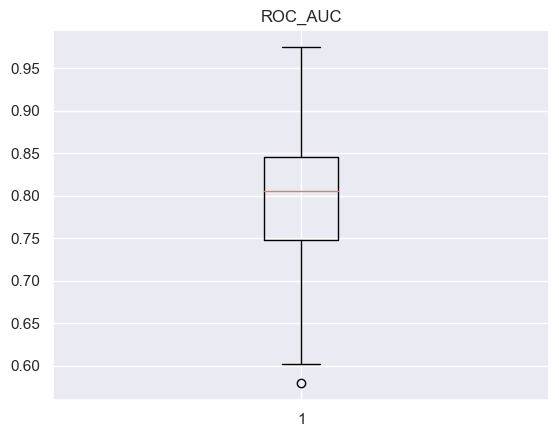

In [13]:
fig1, ax1 = plt.subplots()
ax1.set_title('ROC_AUC')
boxplot = ax1.boxplot(summar1['ROC_AUC'])

In [14]:
print('Q1:', np.percentile(summar1['ROC_AUC'],25))
print('Median:',np.median(summar1['ROC_AUC']))
print('Q3:', np.percentile(summar1['ROC_AUC'],75))

Q1: 0.7476851851851851
Median: 0.805525493025493
Q3: 0.8452884615384616


Distribución accuracy

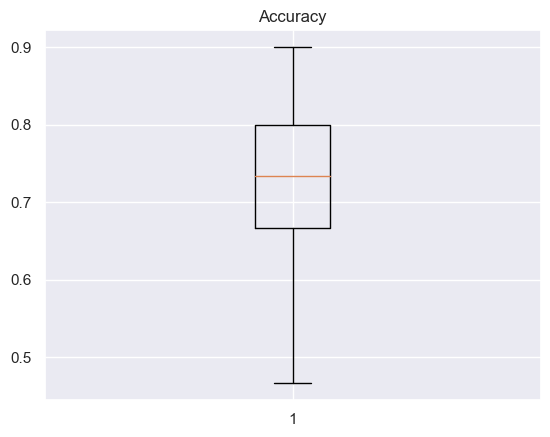

In [15]:
fig2, ax2 = plt.subplots()
ax2.set_title('Accuracy')
boxplot = ax2.boxplot(summar1['Accuracy'])

In [16]:
print('Q1:', np.percentile(summar1['Accuracy'],25))
print('Median:',np.median(summar1['Accuracy']))
print('Q3:', np.percentile(summar1['Accuracy'],75))

Q1: 0.6666666666666666
Median: 0.7333333333333333
Q3: 0.8
